# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS

## Preparation

In [9]:
import duckdb, joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss, log_loss, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import train_test_split

from variables import Variables as vars
import repl_utils, stats_utils

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)
START_TIME = datetime.now()
OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

SAVE_PLOTS = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-20T12:54:12.006277
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 71 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.26.1
pytensor: 2.35.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251220-125412
--------------------



### Options

In [10]:
START_YEAR = 2005
# LightGBM threads
NUM_THREADS = N_CORES
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 50
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

### Load data

In [11]:
con = duckdb.connect("./data/us_births.db", read_only=True)

df = con.execute(
    f"""
    SELECT
        -- (training label) indicated if C or P, not indicated if N, U and missing excluded from training
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'N' THEN 0::UTINYINT
            WHEN uca_downs = 1 THEN 1::UTINYINT
            WHEN uca_downs = 2 THEN 0::UTINYINT
            ELSE NULL
        END AS ca_down_c_p_n,        
        -- ==================== date of birth ====================
        year,
        -- month of birth
        dob_mm,
        -- day of week of birth (1-7)
        dob_wk,
        -- time of birth (0000-2359)
        CASE
            WHEN dob_tt >= 0 AND dob_tt <= 2359 THEN dob_tt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dob_tt,
        -- ==================== birth location ====================
        -- birth place (1: hospital, 2: not hospital, 3: unknown/not stated)
        bfacil3,
        -- ==================== characteristics of baby ====================
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- birth weight (grams)
        CASE
            WHEN dbwt >= 227 AND dbwt <= 8165 THEN dbwt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dbwt,
        -- ==================== characteristics of pregnancy ====================
        -- plurality (1: single... 4 quadpruplet or higher)
        dplural,
        -- month prenatal care began (1 to 10, 0: no prenatal care)
        CASE
            WHEN precare >= 0 AND precare <= 10 THEN precare
            WHEN precare = 99 THEN precare
            ELSE NULL
        END AS precare,
        -- combined gestation estimate
        CASE
            WHEN gestrec10 >= 1 AND gestrec10 <= 10 THEN gestrec10
            WHEN gestrec10 = 99 THEN gestrec10
            ELSE NULL
        END AS gestrec10,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS pwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS wtgain,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END
        AS bmi,
        -- ==================== pregnancy risk factors ====================
        -- pre-pregnancy diabetes
        CASE
            WHEN rf_pdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_pdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_pdiab,
        -- gestational diabetes
        CASE
            WHEN rf_gdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_gdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_gdiab,
        -- pre-pregnancy hypertension
        CASE
            WHEN rf_phype = 'Y' THEN 1::UTINYINT
            WHEN rf_phype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_phype,
        -- gestational hypertension
        CASE
            WHEN rf_ghype = 'Y' THEN 1::UTINYINT
            WHEN rf_ghype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ghype,
        -- hypertension eclampsia
        CASE
            WHEN rf_ehype = 'Y' THEN 1::UTINYINT
            WHEN rf_ehype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ehype,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- infertility treatment used
        CASE
            WHEN rf_inftr = 'Y' THEN 1::UTINYINT
            WHEN rf_inftr = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_inftr,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- ==================== labor and delivery ====================
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- augmentation of labor
        CASE
            WHEN ld_augm = 'Y' THEN 1::UTINYINT
            WHEN ld_augm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_augm,
        -- fetal presentation at delivery
        CASE
            WHEN me_pres >= 1 AND me_pres <= 3 THEN me_pres
            WHEN me_pres = 9 THEN me_pres
            ELSE NULL
        END AS me_pres,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            WHEN dmeth_rec = 9 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- ==================== newborn health ====================
        -- five minute apgar score
        CASE
            WHEN apgar5 >= 10 AND apgar5 <= 10 THEN apgar5
            WHEN apgar5 = 99 THEN apgar5
            ELSE NULL
        END AS apgar5,
        -- ten minute apgar score
        CASE
            WHEN apgar10 >= 10 AND apgar10 <= 10 THEN apgar10
            WHEN apgar10 = 99 THEN apgar10
            ELSE NULL
        END AS apgar10,
        -- assisted ventilation (immediately)
        CASE
            WHEN ab_aven1 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven1 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven1,
        -- assisted ventilation > 6 hrs
        CASE
            WHEN ab_aven6 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven6 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven6,
        -- admitted to nicu
        CASE
            WHEN ab_nicu = 'Y' THEN 1::UTINYINT
            WHEN ab_nicu = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_nicu,
        -- surfactant
        CASE
            WHEN ab_surf = 'Y' THEN 1::UTINYINT
            WHEN ab_surf = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_surf,
        -- antibiotics for newborn
        CASE
            WHEN ab_anti = 'Y' THEN 1::UTINYINT
            WHEN ab_anti = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_anti,
        -- seizures
        CASE
            WHEN ab_seiz = 'Y' THEN 1::UTINYINT
            WHEN ab_seiz = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_seiz,
        -- no_abnorm
        CASE
            WHEN no_abnorm >= 0 AND no_abnorm <= 1 THEN no_abnorm
            WHEN no_abnorm = 9 THEN no_abnorm
            ELSE NULL
        END AS no_abnorm,
        -- ==================== identified disorders ====================
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- anencephaly
        CASE
            WHEN ca_anen = 'Y' THEN 1::UTINYINT
            WHEN ca_anen = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_anen,
        -- meningomyelocele / spina bifida
        CASE
            WHEN ca_mnsb = 'Y' THEN 1::UTINYINT
            WHEN ca_mnsb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_mnsb,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- limb reduction defect
        CASE
            WHEN ca_limb = 'Y' THEN 1::UTINYINT
            WHEN ca_limb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_limb,
        -- cleft lip w/ or w/o cleft palate
        CASE
            WHEN ca_cleft = 'Y' THEN 1::UTINYINT
            WHEN ca_cleft = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cleft,
        -- cleft palate alone
        CASE
            WHEN ca_clpal = 'Y' THEN 1::UTINYINT
            WHEN ca_clpal = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_clpal,
        -- Hypospadias
        CASE
            WHEN ca_hypo = 'Y' THEN 1::UTINYINT
            WHEN ca_hypo = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_hypo,
        -- suspected chromosomal disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            WHEN ca_disor = 'U' THEN 9::UTINYINT
            ELSE NULL
        END AS ca_disor,
        -- no_congen
        CASE
            WHEN no_congen >= 0 AND no_congen <= 1 THEN no_congen
            WHEN no_congen = 9 THEN no_congen
            ELSE NULL
        END AS no_congen,
        -- ==================== maternal characteristics ====================
        -- maternal age in years
        mage_c,
        -- maternal education
        CASE
            WHEN meduc >= 0 AND meduc < 10 THEN meduc
            ELSE NULL
        END AS meduc,
        -- maternal race
        CASE
            WHEN  mracehisp >= 1 AND mracehisp <= 8 THEN mracehisp
            ELSE NULL
        END AS mracehisp,
        -- ==================== paternal characteristics ====================
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- paternal race
        CASE
            WHEN  fracehisp >= 1 AND fracehisp <= 10 THEN fracehisp
            ELSE NULL
        END AS fracehisp,
        -- ==================== socio-economic indicators ====================
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= {START_YEAR} AND ca_down_c_p_n IS NOT NULL
    ORDER BY
        year, dob_mm, dob_wk
    """
).df()

con.close()

df.describe().T

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,count,mean,std,min,25%,50%,75%,max
ca_down_c_p_n,78161818.0,0.000508,0.022542,0.0,0.0,0.0,0.0,1.0
year,78161818.0,2014.217173,5.753869,2005.0,2009.0,2014.0,2019.0,2024.0
dob_mm,78161818.0,6.571835,3.418064,1.0,4.0,7.0,9.0,12.0
dob_wk,78161818.0,4.054011,1.842688,1.0,3.0,4.0,6.0,7.0
dob_tt,5036326.0,124.140967,82.185313,0.0,42.0,125.0,210.0,255.0
bfacil3,78161818.0,1.015354,0.123327,1.0,1.0,1.0,1.0,3.0
sex,78161818.0,0.511585,0.499866,0.0,0.0,1.0,1.0,1.0
dbwt,78100022.0,3261.827446,589.739979,227.0,2963.0,3300.0,3629.0,8165.0
dplural,78161098.0,1.034702,0.189742,1.0,1.0,1.0,1.0,4.0
precare,63370803.0,2.968378,1.54624,0.0,2.0,3.0,3.0,10.0


### Define initial feature set

In [12]:
numeric = [
    "year",
    "dbwt",
    "pwgt_r",
    "wtgain",
    "bmi",
    "mage_c",
    "fagecomb",
]

categorical = [
    "dob_mm",
    "dob_wk",
    "bfacil3",
    "sex",
    "precare",
    "gestrec10",
    "rf_pdiab",
    "rf_gdiab",
    "rf_phype",
    "rf_ghype",
    "rf_ehype",
    "rf_ppterm",
    "rf_inftr",
    "rf_fedrg",
    "rf_artec",
    "no_risks",
    "ld_indl",
    "ld_augm",
    "me_pres",
    "dmeth_rec",
    "apgar5",
    "apgar10",
    "ab_aven1",
    "ab_aven6",
    "ab_nicu",
    "ab_surf",
    "ab_anti",
    "ab_seiz",
    "no_abnorm",
    "ca_anen",
    "ca_mnsb",
    "ca_cchd",
    "ca_cdh",
    "ca_omph",
    "ca_gast",
    "ca_limb",
    "ca_cleft",
    "ca_clpal",
    "ca_hypo",
    "ca_disor",
    "no_congen",
    "meduc",
    "mracehisp",
    "feduc",
    "fracehisp",
    "pay_rec",
    "wic",
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data

In [13]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp, y_tmp, test_size=(VALIDATION_SPLIT/TRAINING_SPLIT), stratify=y_tmp, random_state=RANDOM_SEED
)

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False)

In [14]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}")
print(f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}")
print(f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}")

Training set: 39061040 negatives, 19869 positives, probability positive 0.00050867
Validation set: 19530520 negatives, 9934 positives, probability positive 0.00050864
Calibration set: 19530521 negatives, 9934 positives, probability positive 0.00050864


In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255, # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,

    "seed": RANDOM_SEED,

    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.021267812559750854,
    "num_leaves": 279,
    "min_data_in_leaf": 9106,
    "min_gain_to_split": 0.46403505679141954,
    "feature_fraction": 0.8958378675222805,
    "bagging_fraction": 0.9546259345666808,
    "bagging_freq": 2,
    "lambda_l1": 9.58226179280686,
    "lambda_l2": 9.172194192275149e-08,
  }

## Hyperparameter tuning

In [16]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,

        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),

        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 25000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),

        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),

        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=1),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]

if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(),
                                pruner=optuna.pruners.HyperbandPruner())

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f"  \"{k}\": {v}")

[I 2025-12-20 13:10:36,689] A new study created in memory with name: no-name-c96b3a75-f76a-49e6-b901-f7e6fb4fe46f


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.170337	valid_0's binary_logloss: 0.0048732
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.173883	valid_0's binary_logloss: 0.00479557
[3]	valid_0's average_precision: 0.0675929	valid_0's binary_logloss: 0.00448946
[4]	valid_0's average_precision: 0.0728652	valid_0's binary_logloss: 0.00429295
[5]	valid_0's average_precision: 0.0729325	valid_0's binary_logloss: 0.00423038
[6]	valid_0's average_precision: 0.116208	valid_0's binary_logloss: 0.00419497
[7]	valid_0's average_precision: 0.120051	valid_0's binary_logloss: 0.00414612
[8]	valid_0's average_precision: 0.135323	vali

[I 2025-12-20 13:28:23,868] Trial 0 finished with value: 0.5489592622355232 and parameters: {'learning_rate': 0.024088038990176214, 'num_leaves': 174, 'min_data_in_leaf': 6587, 'min_gain_to_split': 0.9934587281390297, 'feature_fraction': 0.9370342827481655, 'bagging_fraction': 0.6277726740206329, 'bagging_freq': 9, 'lambda_l1': 0.3824249542686079, 'lambda_l2': 1.6187841150876678e-06}. Best is trial 0 with value: 0.5489592622355232.


[507]	valid_0's average_precision: 0.549159	valid_0's binary_logloss: 0.00187214
Early stopping, best iteration is:
[457]	valid_0's average_precision: 0.548959	valid_0's binary_logloss: 0.00187208
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.121726	valid_0's binary_logloss: 0.00505914
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.1545	valid_0's binary_logloss: 0.00475916
[3]	valid_0's average_precision: 0.159787	valid_0's binary_logloss: 0.00455447
[4]	valid_0's average_precision: 0.153935	valid_0's binary_logloss: 0.00433456
[5]	valid_0's average_precision: 0.186731	valid_0's binary_logloss: 0.00419673
[6]	valid_0

[I 2025-12-20 13:52:05,746] Trial 1 finished with value: 0.5528238722448234 and parameters: {'learning_rate': 0.028271437111966675, 'num_leaves': 37, 'min_data_in_leaf': 17147, 'min_gain_to_split': 0.3932602688943272, 'feature_fraction': 0.6552604585625234, 'bagging_fraction': 0.6102602083886189, 'bagging_freq': 8, 'lambda_l1': 6.128005483219935, 'lambda_l2': 1.3292504764524866}. Best is trial 1 with value: 0.5528238722448234.


[752]	valid_0's average_precision: 0.552906	valid_0's binary_logloss: 0.00184829
Early stopping, best iteration is:
[702]	valid_0's average_precision: 0.552824	valid_0's binary_logloss: 0.00184818
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.511833	valid_0's binary_logloss: 0.00303935
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.499704	valid_0's binary_logloss: 0.00281462
[3]	valid_0's average_precision: 0.503426	valid_0's binary_logloss: 0.00275148
[4]	valid_0's average_precision: 0.505655	valid_0's binary_logloss: 0.00270278
[5]	valid_0's average_precision: 0.506216	valid_0's binary_logloss: 0.00267615
[6]	valid

[I 2025-12-20 14:05:42,144] Trial 2 finished with value: 0.5520530085383698 and parameters: {'learning_rate': 0.015291972032415987, 'num_leaves': 293, 'min_data_in_leaf': 812, 'min_gain_to_split': 0.774836524550729, 'feature_fraction': 0.8759029082006023, 'bagging_fraction': 0.6415694684989053, 'bagging_freq': 8, 'lambda_l1': 1.2062608473088146e-05, 'lambda_l2': 1.2770101145647817e-06}. Best is trial 1 with value: 0.5528238722448234.


[445]	valid_0's average_precision: 0.551943	valid_0's binary_logloss: 0.00186656
Early stopping, best iteration is:
[395]	valid_0's average_precision: 0.552053	valid_0's binary_logloss: 0.00186673
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.17918	valid_0's binary_logloss: 0.0154271
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.0106164	valid_0's binary_logloss: 0.0124591
[3]	valid_0's average_precision: 0.0422765	valid_0's binary_logloss: 0.0148229
[4]	valid_0's average_precision: 0.0393522	valid_0's binary_logloss: 0.0156361
[5]	valid_0's average_precision: 0.0372114	valid_0's binary_logloss: 0.0138765
[6]	valid_0

[I 2025-12-20 14:19:55,548] Trial 3 finished with value: 0.5252362918900246 and parameters: {'learning_rate': 0.0581274392056486, 'num_leaves': 118, 'min_data_in_leaf': 4370, 'min_gain_to_split': 0.1023305637125338, 'feature_fraction': 0.9734744374195465, 'bagging_fraction': 0.6600859349197997, 'bagging_freq': 9, 'lambda_l1': 0.04699278502957094, 'lambda_l2': 0.997031698534223}. Best is trial 1 with value: 0.5528238722448234.


[406]	valid_0's average_precision: 0.524819	valid_0's binary_logloss: 0.00253838
Early stopping, best iteration is:
[356]	valid_0's average_precision: 0.525236	valid_0's binary_logloss: 0.00257417
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's average_precision: 0.185679	valid_0's binary_logloss: 0.00467689
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's average_precision: 0.198195	valid_0's binary_logloss: 0.00440603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's average

[I 2025-12-20 14:50:27,824] Trial 4 finished with value: 0.5531509189237951 and parameters: {'learning_rate': 0.021267812559750854, 'num_leaves': 279, 'min_data_in_leaf': 9106, 'min_gain_to_split': 0.46403505679141954, 'feature_fraction': 0.8958378675222805, 'bagging_fraction': 0.9546259345666808, 'bagging_freq': 2, 'lambda_l1': 9.58226179280686, 'lambda_l2': 9.172194192275149e-08}. Best is trial 4 with value: 0.5531509189237951.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.226763	valid_0's binary_logloss: 0.0159302
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:50:32,088] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's average_precision: 0.164406	valid_0's binary_logloss: 0.00550345
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's average_precision: 0.186726	valid_0's binary_logloss: 0.0050881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's average_precision: 0.182959	valid_0's binary_logloss: 0.00500099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's average_precision: 0.0843894	valid_0's binary_loglo

[I 2025-12-20 14:53:57,859] Trial 6 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.194503	valid_0's binary_logloss: 0.00303635
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:54:02,189] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.14093	valid_0's binary_logloss: 0.0285293
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:54:06,573] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.52195	valid_0's binary_logloss: 0.00517791
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.484883	valid_0's binary_logloss: 0.00439714
[3]	valid_0's average_precision: 0.486167	valid_0's binary_logloss: 0.00420393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's average_precision: 0.488419	valid_0's binary_logloss: 0.00408209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's average_precision: 0.489346	valid_0's binary_logloss: 0.00402895
[LightGBM] [Warning] No further splits with positive gain

[I 2025-12-20 14:58:14,579] Trial 9 finished with value: 0.5375867470267607 and parameters: {'learning_rate': 0.06820220947259485, 'num_leaves': 381, 'min_data_in_leaf': 661, 'min_gain_to_split': 0.8425962717755978, 'feature_fraction': 0.868173998298867, 'bagging_fraction': 0.672887334269203, 'bagging_freq': 6, 'lambda_l1': 2.599443940409801, 'lambda_l2': 2.6558487995056265e-07}. Best is trial 4 with value: 0.5531509189237951.


[127]	valid_0's average_precision: 0.536909	valid_0's binary_logloss: 0.00215401
Early stopping, best iteration is:
[77]	valid_0's average_precision: 0.537587	valid_0's binary_logloss: 0.00216521
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.248935	valid_0's binary_logloss: 0.00440612
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.276931	valid_0's binary_logloss: 0.00427065
[3]	valid_0's average_precision: 0.279618	valid_0's binary_logloss: 0.00388735


[I 2025-12-20 14:58:23,085] Trial 10 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.141755	valid_0's binary_logloss: 0.0078318
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:58:27,239] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.117498	valid_0's binary_logloss: 0.00750711
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:58:32,212] Trial 12 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's average_precision: 0.18047	valid_0's binary_logloss: 0.00397596
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:58:36,930] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.235957	valid_0's binary_logloss: 0.00582947
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.280363	valid_0's binary_logloss: 0.00523984
[3]	valid_0's average_precision: 0.259351	valid_0's binary_logloss: 0.00420233


[I 2025-12-20 14:58:45,532] Trial 14 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.0931561	valid_0's binary_logloss: 0.00521552
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:58:50,161] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.198287	valid_0's binary_logloss: 0.00304284
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:58:55,390] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.126259	valid_0's binary_logloss: 0.0031356
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:58:59,965] Trial 17 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.222385	valid_0's binary_logloss: 0.00680111
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:59:05,104] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.146273	valid_0's binary_logloss: 0.00411926
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 14:59:09,525] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.2121	valid_0's binary_logloss: 0.0127227
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.277293	valid_0's binary_logloss: 0.0103418
[3]	valid_0's average_precision: 0.310149	valid_0's binary_logloss: 0.00897159


[I 2025-12-20 14:59:19,149] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.525732	valid_0's binary_logloss: 0.00284132
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.540363	valid_0's binary_logloss: 0.00264869
[3]	valid_0's average_precision: 0.5252	valid_0's binary_logloss: 0.00257962
[4]	valid_0's average_precision: 0.526054	valid_0's binary_logloss: 0.00255398
[5]	valid_0's average_precision: 0.527273	valid_0's binary_logloss: 0.00252949
[6]	valid_0's average_precision: 0.528081	valid_0's binary_logloss: 0.00250836
[7]	valid_0's average_precision: 0.528416	valid_0's binary_logloss: 0.00248738
[8]	valid_0's average_precision: 0.528829	valid_0'

[I 2025-12-20 15:11:37,082] Trial 21 finished with value: 0.5515717445773827 and parameters: {'learning_rate': 0.014031630977652905, 'num_leaves': 323, 'min_data_in_leaf': 562, 'min_gain_to_split': 0.784230586795854, 'feature_fraction': 0.8625253135666732, 'bagging_fraction': 0.6063339118937008, 'bagging_freq': 8, 'lambda_l1': 1.7388355568085508e-06, 'lambda_l2': 1.0910139001437635e-07}. Best is trial 4 with value: 0.5531509189237951.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.383975	valid_0's binary_logloss: 0.00360373
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.422471	valid_0's binary_logloss: 0.00344682
[3]	valid_0's average_precision: 0.420878	valid_0's binary_logloss: 0.00321208


[I 2025-12-20 15:11:43,949] Trial 22 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.34614	valid_0's binary_logloss: 0.00737205
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.467826	valid_0's binary_logloss: 0.00498061
[3]	valid_0's average_precision: 0.475327	valid_0's binary_logloss: 0.00450621
[4]	valid_0's average_precision: 0.513318	valid_0's binary_logloss: 0.00346672
[5]	valid_0's average_precision: 0.51885	valid_0's binary_logloss: 0.00334209
[6]	valid_0's average_precision: 0.525235	valid_0's binary_logloss: 0.00310443
[7]	valid_0's average_precision: 0.522057	valid_0's binary_logloss: 0.00290876
[8]	valid_0's average_precision: 0.525281	valid_0'

[I 2025-12-20 15:18:50,762] Trial 23 finished with value: 0.5498676448422211 and parameters: {'learning_rate': 0.031414084275366114, 'num_leaves': 245, 'min_data_in_leaf': 1086, 'min_gain_to_split': 0.9609498977034784, 'feature_fraction': 0.8392803818468078, 'bagging_fraction': 0.7020942235542864, 'bagging_freq': 7, 'lambda_l1': 2.63915498701493e-07, 'lambda_l2': 2.750741579929517e-07}. Best is trial 4 with value: 0.5531509189237951.


[232]	valid_0's average_precision: 0.547082	valid_0's binary_logloss: 0.00196287
Early stopping, best iteration is:
[182]	valid_0's average_precision: 0.549868	valid_0's binary_logloss: 0.00191631
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.160066	valid_0's binary_logloss: 0.00442983
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:18:55,206] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.436803	valid_0's binary_logloss: 0.0036439
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.467199	valid_0's binary_logloss: 0.00331894
[3]	valid_0's average_precision: 0.468819	valid_0's binary_logloss: 0.0032162


[I 2025-12-20 15:19:02,211] Trial 25 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.223328	valid_0's binary_logloss: 0.00311118
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:19:07,139] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.146799	valid_0's binary_logloss: 0.0058493
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:19:11,123] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.198545	valid_0's binary_logloss: 0.00505414
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.246121	valid_0's binary_logloss: 0.00455136
[3]	valid_0's average_precision: 0.25073	valid_0's binary_logloss: 0.00448262


[I 2025-12-20 15:19:20,460] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.285336	valid_0's binary_logloss: 0.00825133
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:19:24,399] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.121343	valid_0's binary_logloss: 0.00479583
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.12025	valid_0's binary_logloss: 0.00450754
[3]	valid_0's average_precision: 0.116708	valid_0's binary_logloss: 0.0043506


[I 2025-12-20 15:19:30,617] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.417123	valid_0's binary_logloss: 0.00347259
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.520905	valid_0's binary_logloss: 0.00275982
[3]	valid_0's average_precision: 0.515863	valid_0's binary_logloss: 0.00269635
[4]	valid_0's average_precision: 0.520603	valid_0's binary_logloss: 0.00266096
[5]	valid_0's average_precision: 0.523333	valid_0's binary_logloss: 0.00263059
[6]	valid_0's average_precision: 0.524825	valid_0's binary_logloss: 0.00260388
[7]	valid_0's average_precision: 0.526196	valid_0's binary_logloss: 0.00257305
[8]	valid_0's average_precision: 0.527058	valid_

[I 2025-12-20 15:20:13,049] Trial 31 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.436841	valid_0's binary_logloss: 0.00367439
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.468064	valid_0's binary_logloss: 0.0033379
[3]	valid_0's average_precision: 0.467202	valid_0's binary_logloss: 0.0031693


[I 2025-12-20 15:20:19,699] Trial 32 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.329508	valid_0's binary_logloss: 0.00324955
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.347647	valid_0's binary_logloss: 0.00320123
[3]	valid_0's average_precision: 0.358925	valid_0's binary_logloss: 0.00313371
[4]	valid_0's average_precision: 0.365324	valid_0's binary_logloss: 0.00308408
[5]	valid_0's average_precision: 0.367174	valid_0's binary_logloss: 0.0030558
[6]	valid_0's average_precision: 0.369793	valid_0's binary_logloss: 0.00302184
[7]	valid_0's average_precision: 0.37028	valid_0's binary_logloss: 0.00298315
[8]	valid_0's average_precision: 0.370839	valid_0'

[I 2025-12-20 15:28:03,456] Trial 33 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.4169	valid_0's binary_logloss: 0.00415235
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.524748	valid_0's binary_logloss: 0.00275333
[3]	valid_0's average_precision: 0.535193	valid_0's binary_logloss: 0.00259793
[4]	valid_0's average_precision: 0.539181	valid_0's binary_logloss: 0.00254889
[5]	valid_0's average_precision: 0.541693	valid_0's binary_logloss: 0.00249677
[6]	valid_0's average_precision: 0.542832	valid_0's binary_logloss: 0.0024659
[7]	valid_0's average_precision: 0.543262	valid_0's binary_logloss: 0.00244319
[8]	valid_0's average_precision: 0.543383	valid_0's

[I 2025-12-20 15:34:52,878] Trial 34 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.525373	valid_0's binary_logloss: 0.00290526
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.540313	valid_0's binary_logloss: 0.00272943
[3]	valid_0's average_precision: 0.543686	valid_0's binary_logloss: 0.0025635
[4]	valid_0's average_precision: 0.544087	valid_0's binary_logloss: 0.00251974
[5]	valid_0's average_precision: 0.544652	valid_0's binary_logloss: 0.00248927
[6]	valid_0's average_precision: 0.544572	valid_0's binary_logloss: 0.00242646
[7]	valid_0's average_precision: 0.544502	valid_0's binary_logloss: 0.00239872
[8]	valid_0's average_precision: 0.544461	valid_0

[I 2025-12-20 15:44:32,644] Trial 35 finished with value: 0.5528988683548363 and parameters: {'learning_rate': 0.015412951847121622, 'num_leaves': 172, 'min_data_in_leaf': 689, 'min_gain_to_split': 0.5148274811513801, 'feature_fraction': 0.98962345374914, 'bagging_fraction': 0.6486068297707727, 'bagging_freq': 9, 'lambda_l1': 9.967995019183933e-07, 'lambda_l2': 6.325571484729014e-06}. Best is trial 4 with value: 0.5531509189237951.


[380]	valid_0's average_precision: 0.552744	valid_0's binary_logloss: 0.00184165
Early stopping, best iteration is:
[330]	valid_0's average_precision: 0.552899	valid_0's binary_logloss: 0.00184181
[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.513775	valid_0's binary_logloss: 0.00362917
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.425871	valid_0's binary_logloss: 0.00404747
[3]	valid_0's average_precision: 0.445035	valid_0's binary_logloss: 0.00351468


[I 2025-12-20 15:44:39,329] Trial 36 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.202956	valid_0's binary_logloss: 0.0139584
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:44:43,465] Trial 37 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.164101	valid_0's binary_logloss: 0.00373568
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.165253	valid_0's binary_logloss: 0.00360881
[3]	valid_0's average_precision: 0.165405	valid_0's binary_logloss: 0.00352003
[4]	valid_0's average_precision: 0.165545	valid_0's binary_logloss: 0.00344982
[5]	valid_0's average_precision: 0.168164	valid_0's binary_logloss: 0.00339082
[6]	valid_0's average_precision: 0.305022	valid_0's binary_logloss: 0.00336039
[7]	valid_0's average_precision: 0.305115	valid_0's binary_logloss: 0.00331029
[8]	valid_0's average_precision: 0.305118	valid_

[I 2025-12-20 15:44:59,454] Trial 38 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.146837	valid_0's binary_logloss: 0.00437792
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:45:04,344] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.170299	valid_0's binary_logloss: 0.0191356
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.0553203	valid_0's binary_logloss: 0.0117167
[3]	valid_0's average_precision: 0.0566825	valid_0's binary_logloss: 0.0115768


[I 2025-12-20 15:45:12,192] Trial 40 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.525525	valid_0's binary_logloss: 0.0027598
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.540879	valid_0's binary_logloss: 0.00258465
[3]	valid_0's average_precision: 0.543766	valid_0's binary_logloss: 0.00250302
[4]	valid_0's average_precision: 0.54405	valid_0's binary_logloss: 0.00247905
[5]	valid_0's average_precision: 0.545166	valid_0's binary_logloss: 0.00245329
[6]	valid_0's average_precision: 0.545819	valid_0's binary_logloss: 0.00243312
[7]	valid_0's average_precision: 0.545762	valid_0's binary_logloss: 0.00241443
[8]	valid_0's average_precision: 0.545885	valid_0'

[I 2025-12-20 15:51:48,893] Trial 41 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.389036	valid_0's binary_logloss: 0.0038174
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.489039	valid_0's binary_logloss: 0.00277029
[3]	valid_0's average_precision: 0.496011	valid_0's binary_logloss: 0.00272002
[4]	valid_0's average_precision: 0.497724	valid_0's binary_logloss: 0.00268921
[5]	valid_0's average_precision: 0.499799	valid_0's binary_logloss: 0.00265694
[6]	valid_0's average_precision: 0.502486	valid_0's binary_logloss: 0.0026303
[7]	valid_0's average_precision: 0.503885	valid_0's binary_logloss: 0.00260619
[8]	valid_0's average_precision: 0.504779	valid_0'

[I 2025-12-20 15:52:03,713] Trial 42 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.416679	valid_0's binary_logloss: 0.00304025
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.471755	valid_0's binary_logloss: 0.00290785
[3]	valid_0's average_precision: 0.477418	valid_0's binary_logloss: 0.00285116


[I 2025-12-20 15:52:10,249] Trial 43 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.27822	valid_0's binary_logloss: 0.00444814
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.321574	valid_0's binary_logloss: 0.00399172
[3]	valid_0's average_precision: 0.278934	valid_0's binary_logloss: 0.00362484
[4]	valid_0's average_precision: 0.280086	valid_0's binary_logloss: 0.00352924
[5]	valid_0's average_precision: 0.281262	valid_0's binary_logloss: 0.00345684
[6]	valid_0's average_precision: 0.296165	valid_0's binary_logloss: 0.00339562
[7]	valid_0's average_precision: 0.297216	valid_0's binary_logloss: 0.00333174
[8]	valid_0's average_precision: 0.299558	valid_0

[I 2025-12-20 15:52:25,544] Trial 44 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.501214	valid_0's binary_logloss: 0.00288998
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.506066	valid_0's binary_logloss: 0.00273651
[3]	valid_0's average_precision: 0.506616	valid_0's binary_logloss: 0.00269266


[I 2025-12-20 15:52:32,359] Trial 45 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.384375	valid_0's binary_logloss: 0.00565322
Training until validation scores don't improve for 50 rounds


[I 2025-12-20 15:52:37,253] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.249426	valid_0's binary_logloss: 0.00298818
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.352215	valid_0's binary_logloss: 0.00295025
[3]	valid_0's average_precision: 0.434273	valid_0's binary_logloss: 0.00292053
[4]	valid_0's average_precision: 0.436954	valid_0's binary_logloss: 0.0028854
[5]	valid_0's average_precision: 0.439405	valid_0's binary_logloss: 0.00286257
[6]	valid_0's average_precision: 0.437111	valid_0's binary_logloss: 0.00283331
[7]	valid_0's average_precision: 0.439587	valid_0's binary_logloss: 0.00280415
[8]	valid_0's average_precision: 0.439295	valid_0

[I 2025-12-20 15:55:29,575] Trial 47 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.295346	valid_0's binary_logloss: 0.00472776
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.322343	valid_0's binary_logloss: 0.00454557
[3]	valid_0's average_precision: 0.341763	valid_0's binary_logloss: 0.00440696


[I 2025-12-20 15:55:37,520] Trial 48 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[1]	valid_0's average_precision: 0.198348	valid_0's binary_logloss: 0.00931713
Training until validation scores don't improve for 50 rounds
[2]	valid_0's average_precision: 0.264369	valid_0's binary_logloss: 0.00855942
[3]	valid_0's average_precision: 0.104824	valid_0's binary_logloss: 0.00760129
[4]	valid_0's average_precision: 0.113923	valid_0's binary_logloss: 0.00755132
[5]	valid_0's average_precision: 0.11369	valid_0's binary_logloss: 0.00751525
[6]	valid_0's average_precision: 0.109672	valid_0's binary_logloss: 0.0074739
[7]	valid_0's average_precision: 0.106121	valid_0's binary_logloss: 0.00744109
[8]	valid_0's average_precision: 0.0389952	valid_0

[I 2025-12-20 15:55:57,141] Trial 49 pruned. Trial was pruned at iteration 9.


{'learning_rate': 0.021267812559750854, 'num_leaves': 279, 'min_data_in_leaf': 9106, 'min_gain_to_split': 0.46403505679141954, 'feature_fraction': 0.8958378675222805, 'bagging_fraction': 0.9546259345666808, 'bagging_freq': 2, 'lambda_l1': 9.58226179280686, 'lambda_l2': 9.172194192275149e-08} 0.5531509189237951
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 202512
  "num_threads": 24
  "verbosity": 1
  "learning_rate": 0.021267812559750854
  "num_leaves": 279
  "min_data_in_leaf": 9106
  "min_gain_to_split": 0.46403505679141954
  "feature_fraction": 0.8958378675222805
  "bagging_fraction": 0.9546259345666808
  "bagging_freq": 2
  "lambda_l1": 9.58226179280686
  "lambda_l2": 9.172194192275149e-08
  "feature_pre_filter": True


## Train model

In [17]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=5)
    ]
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's average_precision: 0.203098	train's binary_logloss: 0.00393843	valid's average_precision: 0.204605	valid's binary_logloss: 0.00395364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [18]:
best_iter = gbm.best_iteration
gbm.save_model(f"{OUTPUT_DIR}/model_{model_idx}_{datetime.now().strftime("%Y%m%d%H%M")}.txt", num_iteration=best_iter)
gbm.save_model(f"latest_model.txt", num_iteration=best_iter)
print("best_iteration:", best_iter)

best_iteration: 795


### Predict

Produce predictions on validation set

In [19]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

### Evaluate predictions

In [20]:
p_valid_auc = roc_auc_score(y_valid, p_valid)
p_valid_ap  = average_precision_score(y_valid, p_valid)
p_valid_ll  = log_loss(y_valid, p_valid, labels=[0, 1])
p_valid_fpr, p_valid_tpr, p_valid_thresholds = roc_curve(y_valid, p_valid)

print(f"Validation AUC:      {p_valid_auc:.4f}")
print(f"Validation AP:       {p_valid_ap:.6f}")
print(f"Validation log loss: {p_valid_ll:.6f}")

Validation AUC:      0.9661
Validation AP:       0.553148
Validation log loss: 0.001848


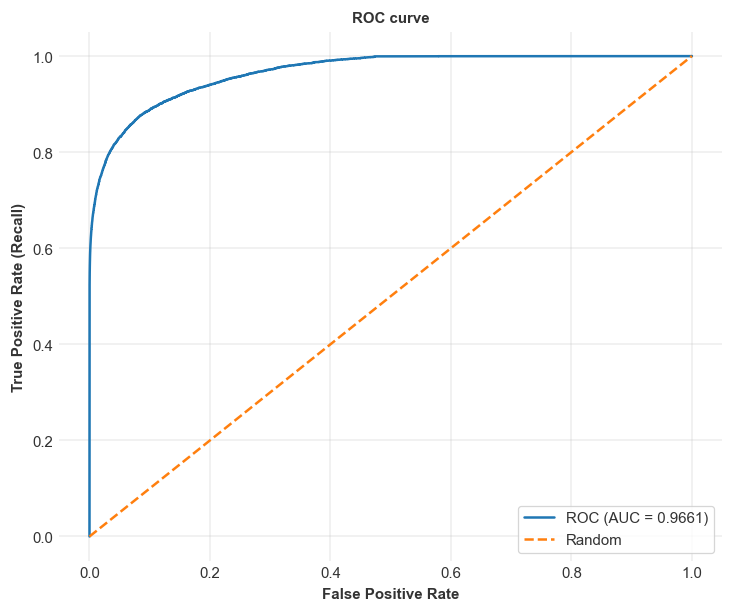

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve")
plt.legend()
plt.show()

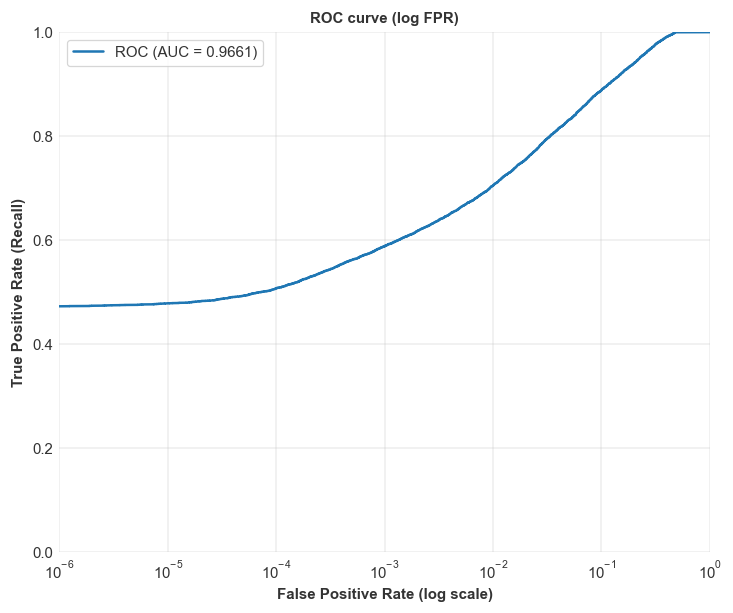

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(p_valid_fpr, p_valid_tpr, label=f"ROC (AUC = {p_valid_auc:.4f})")
plt.xscale("log")
plt.xlim(1e-6, 1)   # adjust lower bound as needed
plt.ylim(0, 1)

plt.xlabel("False Positive Rate (log scale)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC curve (log FPR)")
plt.legend()
plt.show()


#### Feature importance

In [23]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
df_imp_gain

,feature,importance_gain
40,no_congen,3.672553e+06
52,mage_c,3.148950e+06
38,ca_hypo,5.917792e+05
31,ca_cchd,4.784799e+05
39,ca_disor,3.438395e+05
36,ca_cleft,2.734576e+05
47,year,2.320406e+05
24,ab_nicu,1.647667e+05
48,dbwt,8.684419e+04
37,ca_clpal,7.457948e+04


## Evaluation subset for permutation importances and SHAP analysis

In [41]:
y_valid_pos_idx = y_valid[y_valid == 1].index
y_valid_neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(y_valid_pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(y_valid_neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(y_valid_pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(y_valid_neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx]
y_eval = y_valid.loc[eval_idx]

X_eval_np = X_valid.loc[eval_idx].astype(np.float64).replace({pd.NA: np.nan})
y_eval_np = y_valid.loc[eval_idx].astype(np.float64)

In [25]:
def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)

class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)

model_wrapped = LGBMWrapper(gbm)


In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval_np,
    y_eval_np,
    scoring=ap_scorer,
    n_repeats=10,
    n_jobs=NUM_THREADS,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(f"{OUTPUT_DIR}/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
perm_importance

,feature,importance_mean,importance_std
40,no_congen,7.477621e-01,0.001218
24,ab_nicu,6.024439e-02,0.000774
52,mage_c,5.420272e-02,0.000838
47,year,5.212477e-02,0.001000
48,dbwt,2.102038e-02,0.000664
39,ca_disor,1.985872e-02,0.000419
38,ca_hypo,1.432261e-02,0.000622
6,rf_pdiab,1.280009e-02,0.000537
31,ca_cchd,8.946202e-03,0.000585
5,gestrec10,8.834305e-03,0.000310


In [ ]:
# need not NA - some columns have many NAs
distance_0, corr_0 = stats_utils.distance_corr_dissimilarity(X_eval_np)
condensed_0 = squareform(distance_0, checks=True)
dist_linkage_0 = hierarchy.ward(condensed_0)

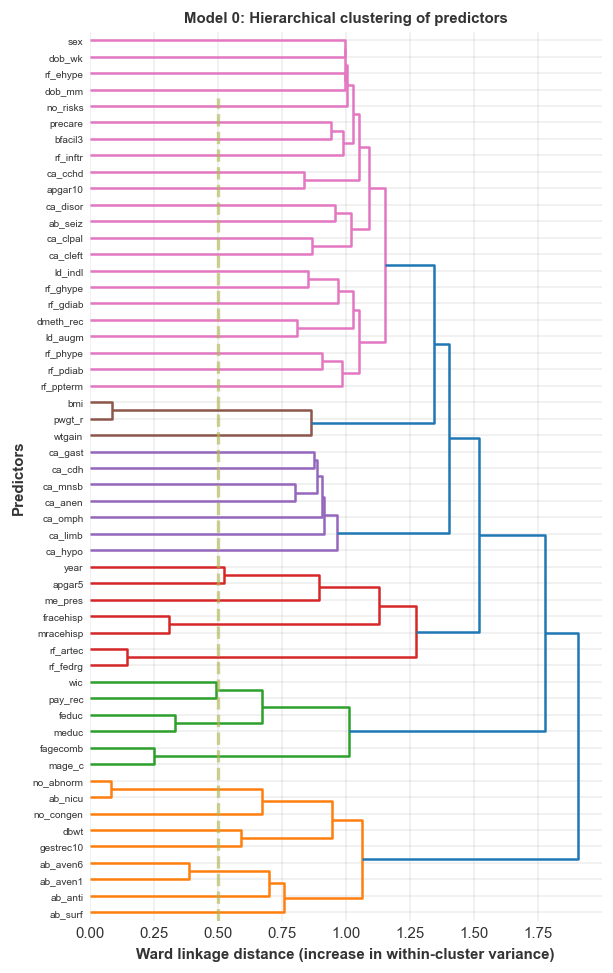

In [40]:
plt.figure(figsize=(5, 8))
dendro_0 = hierarchy.dendrogram(dist_linkage_0, labels=X_eval.columns.to_list(), orientation="right", ax=plt.axes())
plt.vlines(0.5, 0, 500, linestyle="--", color="#b2b4549f", linewidth=2)
plt.xlabel("Ward linkage distance (increase in within-cluster variance)")
plt.ylabel("Predictors")
plt.title(f"Model 0: Hierarchical clustering of predictors")
plt.show()

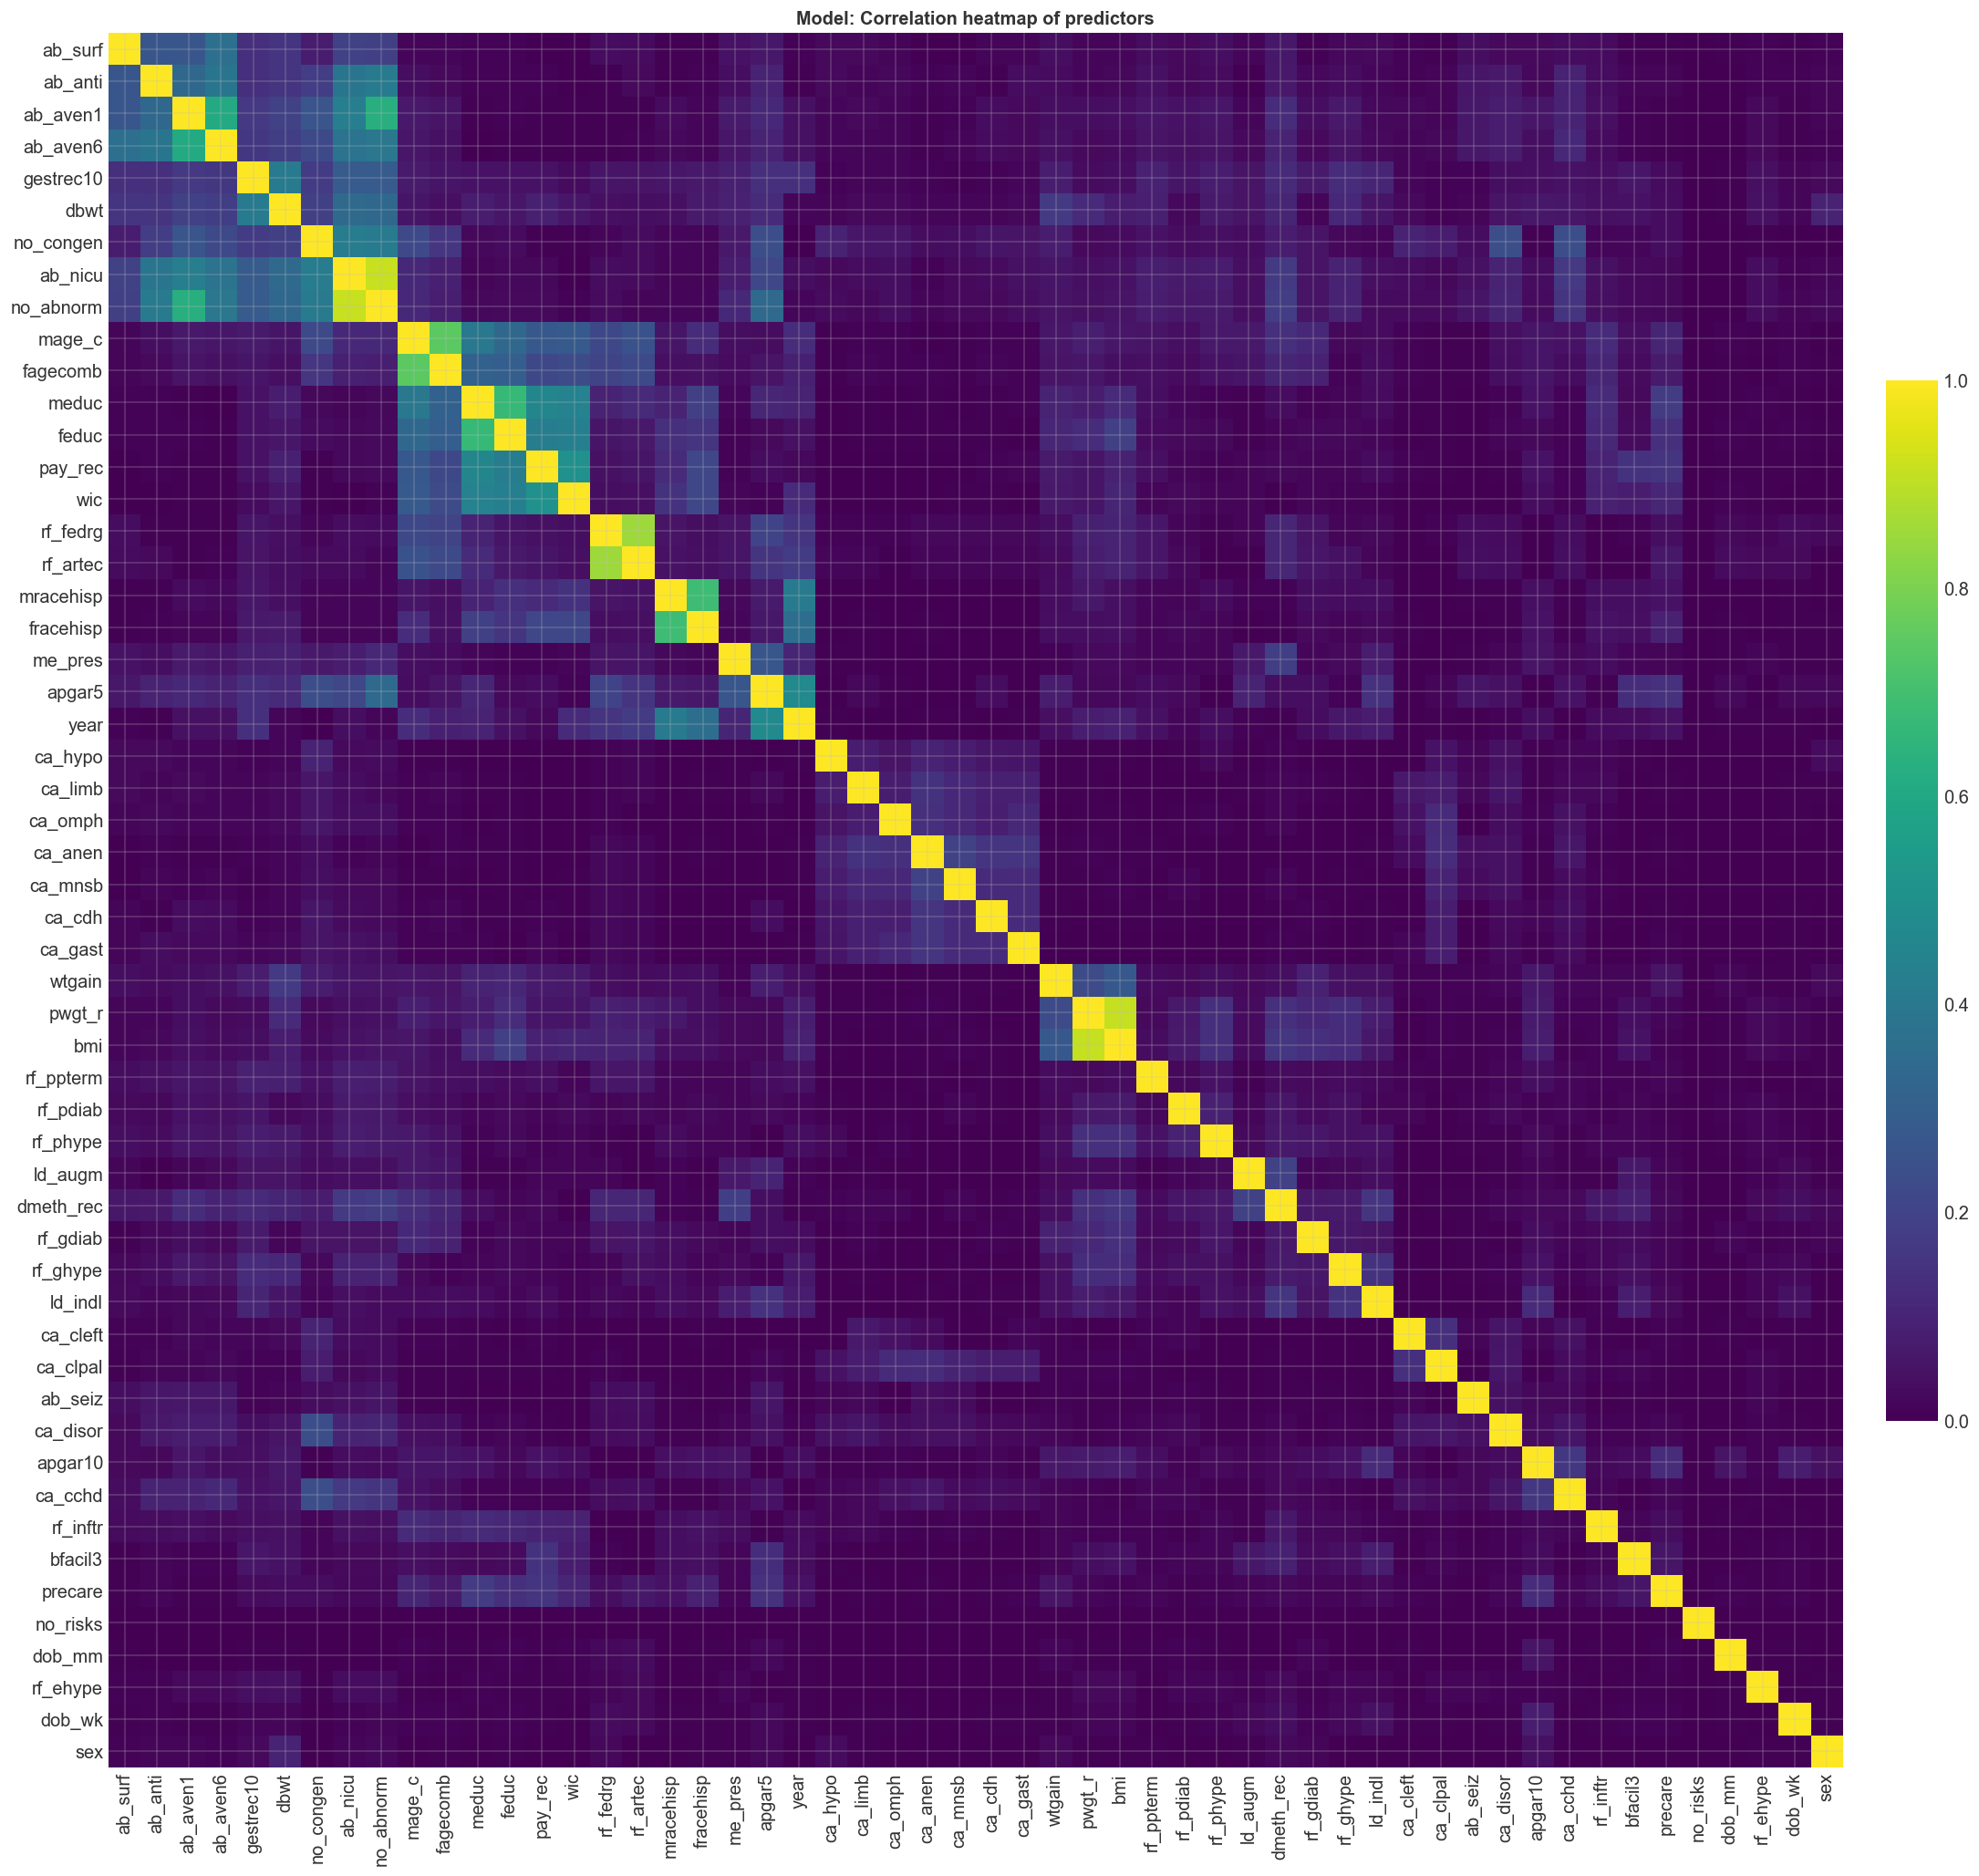

In [35]:
dendro_0_idx = np.arange(0, len(dendro_0["ivl"]))

with plt.rc_context({'ytick.labelsize': 12, 'xtick.labelsize': 12, 'axes.titlesize': 12}):
    plt.figure(figsize=(18, 18))
    plt.set_cmap("viridis")
    ax = plt.axes()
    im = ax.imshow(corr_0[dendro_0["leaves"], :][:, dendro_0["leaves"]])
    ax.set_title(f"Model: Correlation heatmap of predictors")
    ax.set_xticks(dendro_0_idx)
    ax.set_yticks(dendro_0_idx)
    ax.set_xticklabels(dendro_0["ivl"], rotation="vertical")
    ax.set_yticklabels(dendro_0["ivl"])
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.025)
    plt.show()

In [ ]:
# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_eval)
clustering_0 = shap.utils.hclust(X_eval, y_eval, linkage="average", random_state=RANDOM_SEED)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values  # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(f"{OUTPUT_DIR}/model_{model_idx}_shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
shap_importance

We cannot plot millions of observations, so for SHAP analysis, we take a random selection of 10,000 positives and 50,000 negatives.

In [ ]:
# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_eval)
clustering_0 = shap.utils.hclust(X_eval, y_eval, linkage="average", random_state=RANDOM_SEED)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values  # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(f"./output/shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
shap_importance

In [ ]:
with plt.rc_context({'axes.titlesize': 12}):
    plot = plt.figure(figsize=(8, 16))
    ax = plot.subplots()
    ax.set_title(f"Model 0: SHAP values for predictor variables across all samples")
    shap.plots.bar(explanation, max_display=40, ax=ax) # clustering=clustering_0,

In [ ]:
with plt.rc_context({'axes.titlesize': 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model 0: SHAP values for predictor variables across all samples")
    shap.plots.beeswarm(explanation, max_display=40, plot_size=(12, 20))

In [ ]:
X_shap_fp = X_shap.astype("float64")

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation)

## Calibration

In [ ]:
# Top-K precision (what fraction of the top K are truly positive?)
order = np.argsort(-y_valid_predict)
y_sorted = y_valid.to_numpy()[order]

K = 100000
precision_at_k = y_sorted[:K].mean()
recall_at_k = y_sorted[:K].sum() / y_valid.sum()
precision_at_k, recall_at_k

print(f"Precision at {K}: {precision_at_k}")
print(f"Recall at {K}: {recall_at_k}")

In [ ]:
# Precision/recall at a chosen threshold
thr = 0.01
y_hat = (y_valid_predict >= thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_hat, average="binary")
prec, rec, f1

print(f"Precision (threshold={thr}): {prec}")
print(f"Recall (threshold={thr}): {rec}")

In [ ]:
# Top-K precision (what fraction of the top K are truly positive?)
order = np.argsort(-y_valid_predict)
y_sorted = y_valid.to_numpy()[order]

K = 100000
precision_at_k = y_sorted[:K].mean()
recall_at_k = y_sorted[:K].sum() / y_valid.sum()
precision_at_k, recall_at_k

print(f"Precision at {K}: {precision_at_k}")
print(f"Recall at {K}: {recall_at_k}")

In [ ]:
# Precision/recall at a chosen threshold
thr = 0.01
y_hat = (y_valid_predict >= thr).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(y_valid, y_hat, average="binary")
prec, rec, f1

print(f"Precision (threshold={thr}): {prec}")
print(f"Recall (threshold={thr}): {rec}")

## Prediction

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

# p_new = predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=best_iter)